<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
!pip install seaborn==0.9.0 -q

In [0]:
sns.__version__

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import GridSearchCV



In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [128]:
#check for missing values
df.isna().sum()

months_since_last_donation     0
number_of_donations            0
total_volume_donated           0
months_since_first_donation    0
made_donation_in_march_2007    0
dtype: int64

In [127]:
#print unique values to make sure there are no missing values defined in 
#a different way
def unique(df):
  for col in df.columns:
    print(col, df[col].unique())
    
unique(df)    

months_since_last_donation [ 2  0  1  4  5  9  3 12  6 11 10 13  8 14  7 16 15 23 21 18 22 26 35 38
 40 74 20 17 25 39 72]
number_of_donations [50 13 16 20 24  4  7 12  9 46 23  3 10  6  5 14 15 11  8  2 19 17  1 22
 18 38 43 34 44 26 41 21 33]
total_volume_donated [12500  3250  4000  5000  6000  1000  1750  3000  2250 11500  5750   750
  2500  1500  1250  3500  3750  2750  2000   500  4750  4250   250  5500
  4500  9500 10750  8500 11000  6500 10250  5250  8250]
months_since_first_donation [98 28 35 45 77  4 14 22 58 47 15 11 48 49 16 40 34 21 26 64 57 53 69 36
  2 46 52 81 29  9 74 25 51 71 23 86 38 76 70 59 82 61 79 41 33 10 95 88
 19 37 39 78 42 27 24 63 43 75 73 50 60 17 72 62 30 31 65 89 87 93 83 32
 12 18 55  3 13 54]
made_donation_in_march_2007 [1 0]


In [129]:
df.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [59]:
df.describe()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


This is a classification problem, I'll explore more in detail the target distribution 

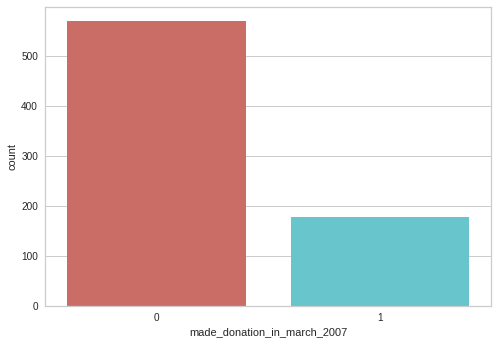

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64


In [136]:
target = 'made_donation_in_march_2007'
sns.countplot(x=target, data=df, palette='hls')
plt.show();
print(df[target].value_counts(normalize=True));

the target class is imbalanced, which can be mitigated by balancing the class using python SMOTE when time allows

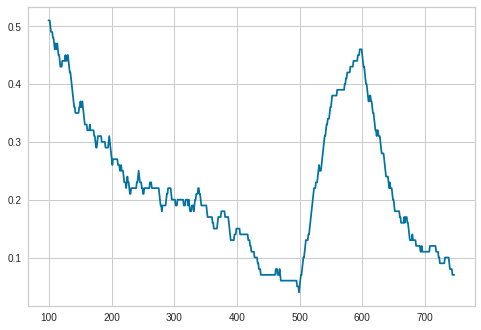

In [137]:
df[target].rolling(100).mean().plot();


## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [138]:
majority_class = df[target].mode()[0]
y_pred = np.full(shape=df[target].shape, fill_value=majority_class)
accuracy_score(df[target], y_pred)

0.7620320855614974

fairly well fitting baseline model, it should be improved though

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

to answer this question, I'll print the classification report first

In [139]:
print(classification_report(df[target], y_pred));

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       570
           1       0.00      0.00      0.00       178

   micro avg       0.76      0.76      0.76       748
   macro avg       0.38      0.50      0.43       748
weighted avg       0.58      0.76      0.66       748



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


getting warning is natural, since the majority_class are all zeros, so presicion and F-score are "ill-defined"

In [140]:
#recall
recall_score(df[target], y_pred)

0.0

as the report showed, the recall is 0

## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [0]:
#Define X and y
X = df.drop(target, axis=1)
y = df[target]

In [0]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True)
    

In [145]:
[array.shape for array in (X_train, X_test, y_train, y_test)]

[(561, 4), (187, 4), (561,), (187,)]

In [0]:
#for feature engineering,make a copy of original dataset, since it's fairly 
#small, to compare the results later
d = df.copy()

In [0]:
#add additional features which might help to improve the model
d['average_donation'] = d['total_volume_donated'] / d['number_of_donations']
d['donation_longevity'] = d['months_since_first_donation'] - d['months_since_last_donation']
d['average_months_for_donation'] = d['donation_longevity']/ d['number_of_donations']
d['if_in_March'] = d['months_since_first_donation']%12 == 0

In [148]:
d.head()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007,donation_longevity,average_months_for_donation,if_in_March
0,2,50,12500,98,1,96,1.920000,False
1,0,13,3250,28,1,28,2.153846,False
2,1,16,4000,35,1,34,2.125000,False
3,2,20,5000,45,1,43,2.150000,False
4,1,24,6000,77,0,76,3.166667,False


In [73]:
d['average_donation'].unique()

array([250.])

well, the column `average donation` contains the same values, I'll drop it

In [0]:
d = d.drop('average_donation', axis=1)

In [0]:
Xd = d.drop(target, axis=1)
yd = d[target]

In [0]:
#split the feature-engineered dataset
#Train-test split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(
        Xd, yd, test_size=0.25, random_state=42, shuffle=True)
    

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [151]:
#check the time of processing
%%time

#import the pipeline and its components
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, SelectKBest

#make the pipeline
pipe = make_pipeline(
    RobustScaler(),
    SelectKBest(f_classif),
    LogisticRegression(solver='lbfgs'))

#solver='lbfgs', class_weight=class_weight

CPU times: user 246 µs, sys: 0 ns, total: 246 µs
Wall time: 250 µs


In [0]:
#let's try to modify the pipeline using a MinMaxScaler and 'newtin-cg' solver
pipe2 = make_pipeline(
    MinMaxScaler(),
    SelectKBest(f_classif),
    LogisticRegression(solver='newton-cg'))

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [153]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'selectkbest__k': [1,2,3,4],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]   
}

gs = GridSearchCV(pipe, 
                  param_grid = param_grid,
                  cv=3,
                  scoring = 'recall',
                  return_train_score=True,
                  verbose=1,
                  iid=False)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
results = pd.DataFrame(gs.cv_results_)
print()
print('Cross-Validation Score:', validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
 ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])



[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    2.0s finished


In [154]:
#try pipe2 with original dataset and param_grid  
#before that, Silent Data Conversion Warnings for MinMaxScaler

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


gs2 = GridSearchCV(pipe2, 
                  param_grid = param_grid,
                  cv=3,
                  scoring = 'recall',
                  return_train_score=True,
                  verbose=1,
                  iid=False)

gs2.fit(X_train, y_train)
validation_score2 = gs2.best_score_
results2 = pd.DataFrame(gs2.cv_results_)
print()
print('Cross-Validation Score:', validation_score2)
print()
print('Best estimator:', gs2.best_estimator_)
print()

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])



[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    1.9s finished


well, the results are the same

In [87]:
#now, try the same grid for the feature-engineered dataset
gsd = GridSearchCV(pipe, 
                  param_grid = param_grid,
                  cv=3,
                  scoring = 'recall',
                  return_train_score=True,
                  verbose=1,
                  iid=False)

gsd.fit(Xd_train, yd_train)

validation_score_d = gsd.best_score_
results_d = pd.DataFrame(gsd.cv_results_)
print()
print('Cross-Validation Score:', validation_score_d)
print()
print('Best estimator:', gsd.best_estimator_)
print()


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
 ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])



[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    2.4s finished


well, the results are exactly the same, will try to improve by polynomial model and selecting features when time allows

In [156]:
#modify params_grid
param_grid2 = {
    'selectkbest__k': [1,2,3,4,5],
    'logisticregression__class_weight': ['balanced', {0:1, 1:3}],
    'logisticregression__C': [5.0, 7.0, 10.0, 15.0]   
}


#finally, let's try modified params with modified pipe and feature-engineered dataset:
gsp = GridSearchCV(pipe2, 
                  param_grid = param_grid2,
                  cv=3,
                  scoring = 'recall',
                  return_train_score=True,
                  verbose=1,
                  iid=False)

gsp.fit(Xd_train, yd_train)
validation_score_p = gsd.best_score_
results_p = pd.DataFrame(gsp.cv_results_)
print()
print('Cross-Validation Score:', validation_score_p)
print()
print('Best estimator:', gsp.best_estimator_)
print()


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=5.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])



[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.3s finished


well' results are the same, still we've tried, should we have enough time, maybe new modified features would help

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [157]:
print()
print('Cross-Validation Score:', validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
 ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])



In [158]:
print()
print('Cross-Validation Score:', validation_score_p)
print()
print('Best estimator:', gsp.best_estimator_)
print()



Cross-Validation Score: 0.8005637773079632

Best estimator: Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7fb3ea618510>)), ('logisticregression', LogisticRegression(C=5.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))])



the score is better than in a simple baseline model, we're in the right direction!

In [159]:
#let's go with the feature-engineered dataset to show selected features:
selected_features = Xd_train.columns[gsp.best_estimator_.named_steps['selectkbest'].get_support()]
selected_features


Index(['months_since_last_donation', 'number_of_donations'], dtype='object')

In [163]:
not_selected_features  = Xd_train.columns[~gsp.best_estimator_.named_steps['selectkbest'].get_support()]
not_selected_features

Index(['total_volume_donated', 'months_since_first_donation',
       'donation_longevity', 'average_months_for_donation', 'if_in_March'],
      dtype='object')

In [160]:
#hmmm, results were interesting let's try to see what we've got in the original dataset
selected_features_original = X_train.columns[gs.best_estimator_.named_steps['selectkbest'].get_support()]
selected_features_original


Index(['months_since_last_donation', 'total_volume_donated'], dtype='object')

In [164]:
not_selected_features_original = X_train.columns[~gs.best_estimator_.named_steps['selectkbest'].get_support()]
not_selected_features_original

Index(['number_of_donations', 'months_since_first_donation'], dtype='object')

Evaluation on the test sets:

In [161]:
# Use the grid search's score method with X_test of original dataset
test_score_original = gs.score(X_test, y_test)
print('Test Score:', test_score_original)

Test Score: 0.7916666666666666


In [162]:
# Use the grid search's score method with Xd_test of modified dataset
test_score_modified = gsp.score(Xd_test, yd_test)
print('Test Score Modified:', test_score_modified)

Test Score Modified: 0.7916666666666666


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [120]:
#Accuracy score  = (Actual POSITIVE + Actual NEGATIVE) / (Actual POSITIVE + 
#Actual NEGATIVE + Predicted POSITIVE + Predicted NEGATIVE)
accuracy_score = (36+85) / (85+8+58+36)
print('The accuracy score is: ',round(accuracy_score,2))

The accuracy score is:  0.65


Calculate precision

In [121]:
#Precision = Actual POSITIVE / (Actual POSITIVE + Actual NEGATIVE)
precision = 36 / (36+58)
print('The precision is', round(precision,2))

The precision is 0.38


Calculate recall

In [122]:
#Recall = Actual POSITIVE / (Actual POSITIVE + Predicted POSITIVE)
recall = 36/(36 + 8)
print('The recall is: ', round(recall,2))

The recall is:  0.82


In [123]:
#F1 Score = 2  (Recall * Precision)  / (Recall + Precision)
f1 = 2 *(recall*precision)/(recall+precision)
print('F1 score is: ', round(f1,2))

F1 score is:  0.52


In [124]:
#False Positive rate = Predicted POSITIVE / (Predicted POSITIVE  + Actual NEGATIVE)
false_positive_rate = 58 / (85+58)
print('The false positive rate is: ', round(false_positive_rate,2))

The false positive rate is:  0.41


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 